# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [4]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.3 which is incompatible.


The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [5]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [6]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [7]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726671e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [8]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.6099999863654375


When finished, you can close the environment.

In [ ]:
#env.close()     # do not use if you're running the next section

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [9]:
# import required packages and files
%load_ext autoreload
%autoreload 2

from ddpg_agent import Agent
from collections import deque
import matplotlib.pyplot as plt
import torch
import pickle

In [29]:
def ddpg(n_episodes=2000, max_timesteps = 1000, window_size=100, win_criteria=30.0, print_every=10, save_every=100,
         test_run = False, saved_state_paths = None):

    if saved_state_paths is not None:                             # loading back intermediate results:
        with open(saved_state_paths[0], 'rb') as f:               # first object in tuple is the scores and deque pickle
            scores_deque, scores = pickle.load(f)
        agent.actor_local.load_state_dict(torch.load(saved_state_paths[1]))   # next object is the actor network
        agent.critic_local.load_state_dict(torch.load(saved_state_paths[2]))  # last object is the critic network
        start_episode = len(scores)+1
    else:                                                   # starting from scratch
        scores_deque = deque(maxlen=window_size) 
        scores = []
        start_episode = 1
    
    for i_episode in range(start_episode, n_episodes+1):
        
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        
        agent.reset()
        episode_scores = np.zeros(num_agents) 
        
        if not test_run:                          # if we're testing, don't actually run the episodes

            for t in range(max_timesteps):
                actions = agent.act(states)
                env_info = env.step(actions)[brain_name]
                next_states = env_info.vector_observations
                rewards = env_info.rewards
                dones = env_info.local_done

                agent.step(states, actions, rewards, next_states, t, dones)
                episode_scores += np.array(rewards)
                states = next_states
                if np.any(dones):
                    break

        episode_score = np.mean(episode_scores) # episode score(s)
        scores_deque.append(episode_score)      # append scores to deque
        scores.append(episode_score)            # append scores to overall array
        average_score = np.mean(scores_deque)   # get the average inside the moving window

        print('\rEpisode: {}\tAverage Score: {:.2f}\tCurrent Score: {:.2f}'.format(i_episode, average_score, episode_score), end="")
        if i_episode % print_every == 0:
            print('\rEpisode: {}\tAverage Score: {:.2f}\tCurrent Score: {:.2f}'.format(i_episode, average_score, episode_score))

        if i_episode % save_every == 0:
            # Saving the objects:
            episode_string = str(i_episode)
            with open('save_state_'+episode_string+'.pkl', 'wb') as f:
                pickle.dump([scores_deque, scores], f)
                torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_'+episode_string+'.pth')
                torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_'+episode_string+'.pth')

            
        if average_score >= win_criteria:
            print('\nEnvironment solved in {} episodes!\tAverage Score: {:.2f}'.format(i_episode, average_score))
            episode_string = str(i_episode)
            with open('save_state_'+episode_string+'.pkl', 'wb') as f:
                pickle.dump([scores_deque, scores], f)
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_solved.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_solved.pth')
            break

    np.save('scores.npy', scores)
    return scores


# Test Code
Test functionality without actually running the episodes.


In [18]:
agent = Agent(state_size=state_size, action_size=action_size, random_seed=60)

test_scores = ddpg(n_episodes=1000, print_every=10, save_every=100, test_run=True)


Created an Agent
Episode: 10	Average Score: 0.00	Current Score: 0.00
Episode: 20	Average Score: 0.00	Current Score: 0.00
Episode: 30	Average Score: 0.00	Current Score: 0.00
Episode: 40	Average Score: 0.00	Current Score: 0.00
Episode: 50	Average Score: 0.00	Current Score: 0.00
Episode: 60	Average Score: 0.00	Current Score: 0.00
Episode: 70	Average Score: 0.00	Current Score: 0.00
Episode: 80	Average Score: 0.00	Current Score: 0.00
Episode: 90	Average Score: 0.00	Current Score: 0.00
Episode: 100	Average Score: 0.00	Current Score: 0.00
Episode: 110	Average Score: 0.00	Current Score: 0.00
Episode: 120	Average Score: 0.00	Current Score: 0.00
Episode: 130	Average Score: 0.00	Current Score: 0.00
Episode: 140	Average Score: 0.00	Current Score: 0.00
Episode: 150	Average Score: 0.00	Current Score: 0.00
Episode: 160	Average Score: 0.00	Current Score: 0.00
Episode: 170	Average Score: 0.00	Current Score: 0.00
Episode: 180	Average Score: 0.00	Current Score: 0.00
Episode: 190	Average Score: 0.00	Curre

# Train an agent

Created an Agent
Episode: 200	Average Score: 9.87	Current Score: 11.89
Episode: 210	Average Score: 9.62	Current Score: 1.40
Episode: 220	Average Score: 9.35	Current Score: 1.32
Episode: 230	Average Score: 9.12	Current Score: 3.21
Episode: 240	Average Score: 8.84	Current Score: 10.34
Episode: 250	Average Score: 9.06	Current Score: 3.596
Episode: 260	Average Score: 10.05	Current Score: 17.87
Episode: 270	Average Score: 11.01	Current Score: 29.37
Episode: 280	Average Score: 12.52	Current Score: 20.02
Episode: 290	Average Score: 13.65	Current Score: 32.41
Episode: 300	Average Score: 15.08	Current Score: 36.93
Episode: 310	Average Score: 18.11	Current Score: 39.15
Episode: 320	Average Score: 21.12	Current Score: 38.13
Episode: 330	Average Score: 24.18	Current Score: 37.86
Episode: 340	Average Score: 27.02	Current Score: 32.05
Episode: 350	Average Score: 29.27	Current Score: 38.48
Episode: 354	Average Score: 30.11	Current Score: 38.05
Environment solved in 254 episodes!	Average Score: 30.11


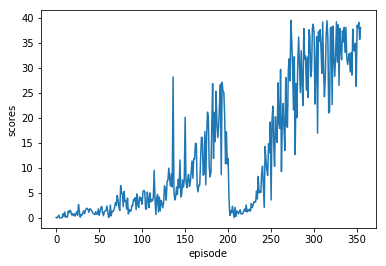

In [31]:
# Initialize Feed-forward DNNs for Actor and Critic models. 
agent = Agent(state_size=state_size, action_size=action_size, random_seed=60)

all_scores = ddpg(n_episodes=1000, print_every=10, saved_state_paths=("save_state_200.pkl","checkpoint_actor_200.pth","checkpoint_critic_200.pth"))

plt.figure()
plt.plot(all_scores)
plt.xlabel("episode")
plt.ylabel("scores")
plt.show()
